# Generate protein with Galactica + retrieval

## Retrieve associated with proteins with the input condition

In [1]:
import pandas as pd
import os, json
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5,6,7"
import torch
import numpy as np
# retrieve relevant proteins by inputting the target disease
# input_disease = "malignant lymphoma"

In [2]:
df_dis = pd.read_csv("./data/Processed/disease.csv")

In [3]:
df_dis["mondo_name"].value_counts()

mondo_name
familial thoracic aortic aneurysm and aortic dissection      84
asthma                                                       40
obstructive sleep apnea syndrome                             39
depressive disorder                                          38
inherited hemoglobinopathy                                   35
                                                             ..
caudal regression-sirenomelia spectrum                        1
qualitative or quantitative defects of titin                  1
partial deletion of the long arm of chromosome 2              1
epilepsy, nocturnal frontal lobe                              1
self-limited familial and non-familial infantile seizures     1
Name: count, Length: 22205, dtype: int64

In [4]:
# dis = df_dis[df_dis["mondo_id"] == 5062].iloc[0]
# dis
dis = df_dis[df_dis["mondo_name"] == "depressive disorder"].iloc[0]
dis

node_index                                           27933
mondo_id                                              2050
mondo_name                             depressive disorder
definition    A melancholy feeling of sadness and despair.
Name: 36031, dtype: object

In [5]:
# load dis emb
import pickle
with open("/home/ec2-user/data/embeddings/esm2b_unimo_pubmedbert/disease.pkl","rb") as f:
    raw_dis = pickle.load(f)
raw_dis.keys()

dict_keys(['node_index', 'embedding'])

In [6]:
dis_node_index = np.array(raw_dis["node_index"])
dis_node_emb =  np.array(raw_dis["embedding"])

In [7]:
dis_node_emb.shape

(17080, 768)

In [8]:
dis_raw_emb = dis_node_emb[dis_node_index==dis["node_index"]]

In [9]:
# load bridge model
from src.model import BindingModel
from src.inference import BridgeInference
checkpoint_dir = "./checkpoints/bind-openke-benchmark-6-layer-unimol"
with open(os.path.join(checkpoint_dir, "model_config.json"), "r") as f:
    model_config = json.load(f)
model = BindingModel(**model_config)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "pytorch_model.bin")))
model = BridgeInference(model)

In [10]:
# transform disease emb to protein space
tr_pro_emb = model.transform(
    x = torch.tensor(dis_raw_emb),
    src_type = 2, # disease
    tgt_type = 1, # protein
    rel_type = 6, # associate with
)

In [11]:
# load pre-encoded protein embeddings and project for retrieval
with open("./data/embeddings/esm2b_unimo_pubmedbert/protein.pkl", "rb") as f:
    pro_raw = pickle.load(f)
pro_emb = torch.tensor(pro_raw["embedding"], dtype=torch.float32)
pro_emb = model.project(
    x = pro_emb,
    src_type = 1,
)
pro_idx = torch.tensor(pro_raw["node_index"])
df_pro = pd.read_csv("/home/ec2-user/data/Processed/protein.csv")

In [12]:
def retrieve_topk_protein(tgt, topk=10):
    """Args:
    tgt: emb with [1, dim]
    """
    cossim = torch.cosine_similarity(tgt, pro_emb, dim=1)
    top_k = torch.topk(cossim, k=topk, dim=0)
    retrieved = df_pro.set_index('node_index').loc[pro_idx[top_k.indices].numpy()]
    return retrieved

In [13]:
res_pro = retrieve_topk_protein(tr_pro_emb, 20)
for v in res_pro["node_name"]:
    print(v)
for v in res_pro["sequence"]:
    print(v)

DRD2
HTR1A
OPRM1
HTR2A
HTR2C
IL1B
BDNF
DRD1
CNR1
PENK
TPH1
GRIA2
POMC
HTR1B
HTR4
DRD3
GRIN1
GRIA1
GRIK2
IL6
MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIAVIVFGNVLVCMAVSREKALQTTTNYLIVSLAVADLLVATLVMPWVVYLEVVGEWKFSRIHCDIFVTLDVMMCTASILNLCAISIDRYTAVAMPMLYNTRYSSKRRVTVMISIVWVLSFTISCPLLFGLNNADQNECIIANPAFVVYSSIVSFYVPFIVTLLVYIKIYIVLRRRRKRVNTKRSSRAFRAHLRAPLKGNCTHPEDMKLCTVIMKSNGSFPVNRRRVEAARRAQELEMEMLSSTSPPERTRYSPIPPSHHQLTLPDPSHHGLHSTPDSPAKPEKNGHAKDHPKIAKIFEIQTMPNGKTRTSLKTMSRRKLSQQKEKKATQMLAIVLGVFIICWLPFFITHILNIHCDCNIPPVLYSAFTWLGYVNSAVNPIIYTTFNIEFRKAFLKILHC
MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAAIALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCCTSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPEDRSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADTRHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGNSKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLPFFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFCRQ
MDSSAAPTNASNCTDALAYSSCSPA

## Generate with prompt

In [14]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("GeorgiaTechResearchInstitute/galactica-30b-evol-instruct-70k")
model = AutoModelForCausalLM.from_pretrained("GeorgiaTechResearchInstitute/galactica-30b-evol-instruct-70k", device_map="auto", torch_dtype=torch.bfloat16, cache_dir="/home/ec2-user/checkpoints")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/targets/x86_64-linux/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/ec2-user/miniconda3/envs/py39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/home/ec2-user/miniconda3/envs/py39/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /home/ec2-user/miniconda3/envs/py39 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
def generate_answer(input_text, max_new_tokens=128, temperature=0.7, top_k=40):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids, max_new_tokens=max_new_tokens,
                            top_k=top_k,
                            do_sample=True,
                            temperature=temperature,
                            repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0])

In [50]:
prompt_template = """### Instruction:
{instruction}

### Response: [START_I_SMILES]"""

prompt = prompt_template.format_map(
    {"instruction":f"""Depressive disorder is a common mental disorder. It involves a depressed mood or loss of pleasure or interest in activities for long periods of time.

    We want to design a drug, which can be targeting one of the following proteins:
    
    DRD2 - dopamine receptor D2
    HTR1A - 5-hydroxytryptamine receptor 1A
    OPRM1 - opioid receptor mu 1
    HTR2A - 5-hydroxytryptamine receptor 2A
    HTR2C - 5-hydroxytryptamine receptor 2C
    IL1B -  interleukin 1 beta
    BDNF - brain derived neurotrophic factor
    CNR1 - cannabinoid receptor 1
    PENK - proenkephalin
    TPH1 - tryptophan hydroxylase 1

    to treat depressive disorder.

The drug treats depressive disorder by being a selective dopamine receptor antagonist, hence inhibiting dopaminergic hyperactivity. \
     Generate the most possible SMILES structure of this drug that treats depressive disorder.
""",}
)

print(prompt)


### Instruction:
Depressive disorder is a common mental disorder. It involves a depressed mood or loss of pleasure or interest in activities for long periods of time.

    We want to design a drug, which can be targeting one of the following proteins:
    
    DRD2 - dopamine receptor D2
    HTR1A - 5-hydroxytryptamine receptor 1A
    OPRM1 - opioid receptor mu 1
    HTR2A - 5-hydroxytryptamine receptor 2A
    HTR2C - 5-hydroxytryptamine receptor 2C
    IL1B -  interleukin 1 beta
    BDNF - brain derived neurotrophic factor
    CNR1 - cannabinoid receptor 1
    PENK - proenkephalin
    TPH1 - tryptophan hydroxylase 1

    to treat depressive disorder.

The drug treats depressive disorder by being a selective dopamine receptor antagonist, hence inhibiting dopaminergic hyperactivity.      Generate the most possible SMILES structure of this drug that treats depressive disorder.


### Response: [START_I_SMILES]


In [51]:
# generate new molecules
outputs = generate_answer(prompt, max_new_tokens=256, temperature=1.0, top_k=50)
print(outputs)

### Instruction:
Depressive disorder is a common mental disorder. It involves a depressed mood or loss of pleasure or interest in activities for long periods of time.

    We want to design a drug, which can be targeting one of the following proteins:
    
    DRD2 - dopamine receptor D2
    HTR1A - 5-hydroxytryptamine receptor 1A
    OPRM1 - opioid receptor mu 1
    HTR2A - 5-hydroxytryptamine receptor 2A
    HTR2C - 5-hydroxytryptamine receptor 2C
    IL1B -  interleukin 1 beta
    BDNF - brain derived neurotrophic factor
    CNR1 - cannabinoid receptor 1
    PENK - proenkephalin
    TPH1 - tryptophan hydroxylase 1

    to treat depressive disorder.

The drug treats depressive disorder by being a selective dopamine receptor antagonist, hence inhibiting dopaminergic hyperactivity.      Generate the most possible SMILES structure of this drug that treats depressive disorder.


### Response: [START_I_SMILES]CC1=C(C(=O)NC2C(=O)N3C2SC(C)(C)C3C(=O)[O-])C(C2=CC=CC=C2)=NO1[END_I_SMILES]

Ans

In [2]:
# compute drug SMILES similarity
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

df = pd.read_csv("./data/DrugBank/drugbank.csv")
mol_df = df[df["type"] == "SmallMoleculeDrug"].reset_index(drop=True)
mol_df = mol_df.drop_duplicates(subset=["moldb_smiles"]).reset_index(drop=True)

/tmp/ipykernel_12865/2630363205.py:7: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/DrugBank/drugbank.csv")


In [21]:
c_smiles = []
dbid = []
title = []
for i,row in mol_df.iterrows():
    ds = row["moldb_smiles"]
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
        dbid.append(row["drugbank_id"])
        title.append(row["title"])
    except:
        print("Invalid SMILES:", ds)
ms = [Chem.MolFromSmiles(x) for x in c_smiles]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]
import numpy as np
dbid, title = np.array(dbid), np.array(title)

[17:24:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:24:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:24:27] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES: [H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H]
Invalid SMILES: [H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N]([H])([H])[H]
Invalid SMILES: [H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]11OC(=O)C(=O)O1
Invalid SMILES: nan


[17:24:27] Explicit valence for atom # 1 Cl, 4, is greater than permitted


Invalid SMILES: O=[Cl]=O


[17:24:28] Explicit valence for atom # 2 O, 3, is greater than permitted
[17:24:28] SMILES Parse Error: syntax error while parsing: \N
[17:24:28] SMILES Parse Error: Failed parsing SMILES '\N' for input: '\N'
[17:24:28] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES: O=C1[O-][Gd+3]234567[O]=C(C[N]2(CC[N]3(CC([O-]4)=O)CC[N]5(CC(=[O]6)NC)CC(=O)[O-]7)C1)NC
Invalid SMILES: \N
Invalid SMILES: [H][N]([H])([H])[Pt]1(OCC(=O)O1)[N]([H])([H])[H]


[17:24:28] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[17:24:28] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'


Invalid SMILES: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


## first generated molecule

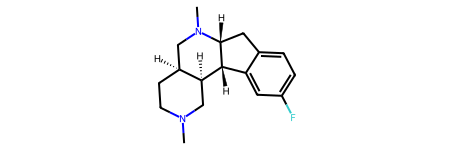

In [3]:
tgt_smiles = "CN1CC[C@H]2CN(C)[C@@H]3Cc4ccc(F)cc4[C@@H]3[C@H]2C1"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [4]:
from rdkit.Chem import Draw
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [64]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['Levorphanol' 'dexamethasone' 'STOPAIN topical gel'
 'Butorphanol tartrate' 'Rotigotine' 'Tapentadol PR' '4-Methylpyrazole'
 'ketorolac' 'Niferex' 'LDX 30 mg']
Drug ID ['DB00854' 'DB00514' 'DB00652' 'DB00611' 'DB05271' 'DB06204' 'DB01213'
 'DB03754' 'DB00139' 'DB01255']
Similarity [0.64022663 0.62833487 0.6119403  0.56009245 0.53855879 0.53433476
 0.53125    0.53125    0.53125    0.52953586]


AttributeError: 'ExplicitBitVect' object has no attribute 'GetAtomWithIdx'

## second generated molecule

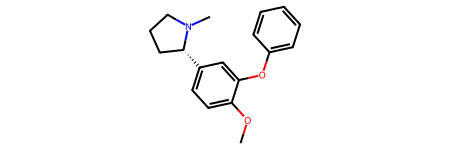

In [71]:
tgt_smiles = "CN1CCC[C@H]1C2=CC(=C(C=C2)OC)OC3=CC=CC=C3"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [72]:
from rdkit.Chem import Draw
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [73]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['opioid receptor kappa antagonist' 'SD-809' 'tetrabenazine or placebo'
 'terameprocol' 'GSK1014802 high dose' 'NBI-98854' 'RO4876904'
 'ACT-078573 and matching placebo' 'mivacurium chloride'
 'Cisatracurium infusion']
Drug ID ['DB12341' 'DB12161' 'DB04844' 'DB12226' 'DB11706' 'DB11915' 'DB12268'
 'DB06673' 'DB01226' 'DB00565']
Similarity [0.60089686 0.59317585 0.59317585 0.57701711 0.5740458  0.56106409
 0.56062425 0.55717762 0.55687831 0.55347594]


### generated molecule

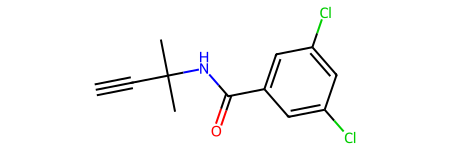

In [61]:
tgt_smiles = "C#CC(C)(C)NC(=O)C1=CC(Cl)=CC(Cl)=C1"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [62]:
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [46]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['CPI-1189' 'procarbazine hydrochloride' 'Moclobemide' 'Emeramide'
 'METOCLOPRAMIDE' 'dexloxiglumide' 'procainamide'
 'Aminohippurate Sodium Inj 20%' 'JNJ-31001074' 'bezafibrate + diflunisal']
Drug ID ['DB12311' 'DB01168' 'DB01171' 'DB12192' 'DB01233' 'DB04856' 'DB01035'
 'DB00345' 'DB12299' 'DB01393']
Similarity [0.61980831 0.6097561  0.58675079 0.57432432 0.57425743 0.57416268
 0.56291391 0.56065574 0.55027933 0.54787234]


NameError: name 'CPI' is not defined